In [6]:
%reset
import numpy as np
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import slic
import time
import matplotlib.pyplot as plt
import scipy
import pickle
import os

#path = "D:/cbr/VP2/VP2_SoilMapping/Processed/"
#folder = "Gempelen/"
#filename = "Stack_6Channels_clipped.tif"
folderpath = "D:/cbr/" #os.path.join(path, folder)
#filepath = os.path.join(folderpath, filename)

filepath = "D:/cbr/Wiese.tif"
print(filepath)
## based on tutorial from https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/

#naip_fn = "D:/cbr/VP2/VP2_SoilMapping/Processed/Wetzwil_Ortho/prediction2/Stack_Wetzwil_6channels.tif"
#naip_fn = "D:/cbr/VP2/VP2_SoilMapping/Processed/Gempelen/Stack_6Channels_clipped.tif"
#naip_fn = "D:/cbr/VP2/VP2_SoilMapping/CodeOutput/output_file_channelFusion_2.tif"
naip_fn = filepath
load_model = pickle.load(open('classifier_prediction_model.sav', "rb"))

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

nbands = naip_ds.RasterCount
band_data = []

print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
        band = naip_ds.GetRasterBand(i).ReadAsArray()
        band_data.append(band)

band_data = np.dstack(band_data)

D:/cbr/Wiese.tif
bands 6 rows 19915 columns 19951


In [7]:
# scale image values from 0.0 - 1.0
#band_data[np.isnan(band_data)] = 0
band_data[np.isnan(band_data)] = -9999.0
img = exposure.rescale_intensity(band_data, in_range= (0.0, 225))

# do segmentation multiple options with quickshift and slic
seg_start = time.time()
# segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
segments = slic(img, n_segments=500, compactness=0.1, start_label = 1, multichannel="TRUE", convert2lab=False)
print('segments complete', time.time() - seg_start)

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

segments complete 753.2021548748016


In [8]:
segment_ids = np.unique(segments)
objects = []
object_ids = [] 
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

In [9]:
load_model = pickle.load(open('classifier_prediction_model_middle.sav', "rb"))


predicted = load_model.predict(objects)

clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass

print('Prediction applied to numpy array')

mask = np.sum(img, axis=2)
mask[mask> 0] = 1.0
mask[mask == 0] = -1.0

clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0
 
print('Saving classification to raster')
def CreateGeoTiff(Name, Array, driver, GeoT, Projection, DataType):
    DataSet = driver.Create(Name, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    DataSet.GetRasterBand(1).SetNoDataValue(-9999.0)
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet.FlushCache()
    return Name

CreateGeoTiff(os.path.join(folderpath, "Wiese_Pred_6Channels_exact.tif"), clf, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
print('Done')

Prediction applied to numpy array
Saving classification to raster
Done


C:\Users\st1154414\.conda\envs\pygdal\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (177412032 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


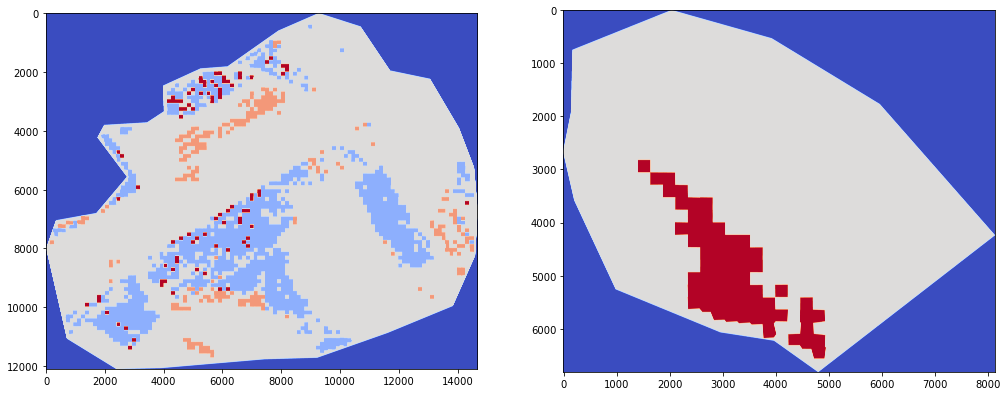

In [10]:
import matplotlib as mp
import matplotlib.pyplot as plt

img2=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/Wetzwil_Ortho/prediction2/Prediction_rgb_dem_ndvi_nir_10000.tif')
img=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/prediction_Wetzwil_gross.tif')


fig, ax = plt.subplots(1, 2, figsize=(17,12))
ax[0].imshow(img2[:, :, 0], cmap=plt.cm.coolwarm)
ax[1].imshow(img[:, :, 0], cmap=plt.cm.coolwarm)
